In [7]:
import scanpy as sc
import pandas as pd
import numpy as np

import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [16]:
healthy = sc.read_h5ad("GSE165080_healthy.h5ad")

In [69]:
healthy.obs

,Age,Gender,BioSample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type_1,cell_type_2,cell_type_3
AAACCTGAGAGTTGGC-1,34,female,SAMN17379694,3734,3734,11946.0,529.0,4.428260,2,Mono,CD14 Mono,CD14 Mono
AAACCTGAGGGCTTGA-1,34,female,SAMN17379694,2001,2001,4745.0,338.0,7.123288,20,other T,gdT,CD8 TEM_6
AAACCTGCAAGCTGTT-1,34,female,SAMN17379694,2471,2471,7979.0,384.0,4.812633,5,CD8 T,CD8 Naive,CD8 Naive_2
AAACCTGCAATAAGCA-1,34,female,SAMN17379694,1487,1487,2865.0,371.0,12.949389,9,NK,NK,NK_2
AAACCTGCAATGTAAG-1,34,female,SAMN17379694,2423,2423,6729.0,550.0,8.173576,9,CD8 T,CD8 TCM,CD8 TCM_3
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGAACG-1,39,male,SAMN17379591,1054,1054,2108.0,136.0,6.451612,4,CD4 T,CD4 TCM,CD4 TCM_1
TTTGTCACACGGTAGA-1,39,male,SAMN17379591,757,757,1257.0,199.0,15.831344,16,CD8 T,NK,NK_1
TTTGTCACAGGACGTA-1,39,male,SAMN17379591,1882,1882,5846.0,178.0,3.044817,4,CD4 T,CD4 TCM,CD4 TCM_1
TTTGTCAGTCCAGTGC-1,39,male,SAMN17379591,1407,1407,3106.0,194.0,6.245975,15,CD8 T,CD8 TEM,CD8 TEM_6


C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


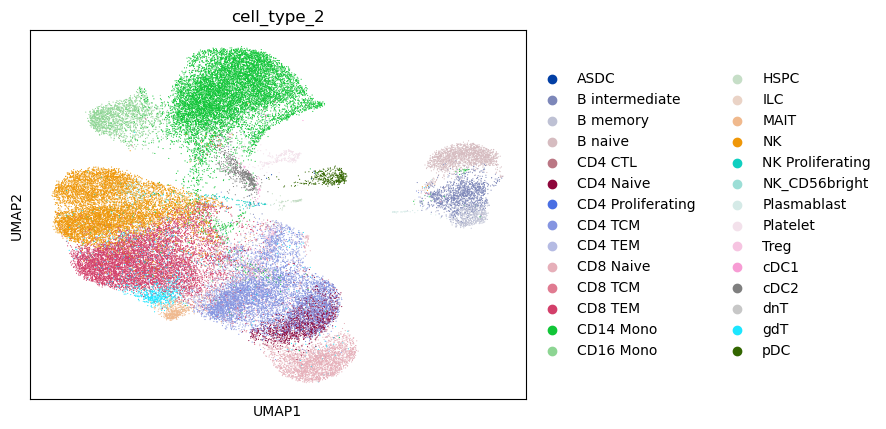

In [160]:
sc.pl.umap(healthy, color = "cell_type_2")

# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [116]:
healthy.obs.cell_type_2

AAACCTGAGAGTTGGC-1    CD14 Mono
AAACCTGAGGGCTTGA-1          gdT
AAACCTGCAAGCTGTT-1    CD8 Naive
AAACCTGCAATAAGCA-1           NK
AAACCTGCAATGTAAG-1      CD8 TCM
                        ...    
TTTGTCAAGCTGAACG-1      CD4 TCM
TTTGTCACACGGTAGA-1           NK
TTTGTCACAGGACGTA-1      CD4 TCM
TTTGTCAGTCCAGTGC-1      CD8 TEM
TTTGTCATCCTGTACC-1    CD4 Naive
Name: cell_type_2, Length: 46160, dtype: category
Categories (28, object): ['ASDC', 'B intermediate', 'B memory', 'B naive', ..., 'cDC2', 'dnT', 'gdT', 'pDC']

In [22]:
BioSample = healthy.obs.BioSample

personal = {}
personal_df = {}
for i in BioSample:
    if i not in personal:
        personal[i] = healthy[healthy.obs["BioSample"] == i, :]
        personal_df[i] = healthy[healthy.obs["BioSample"] == i, :]
len(personal)

11

In [23]:
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])
age

[34, 34, 35, 39, 39, 40, 44, 50, 51, 52, 56]

In [24]:
#personal["SAMN17379721"].obs.cell_type_l1

#NK_1 = personal["SAMN17379721"][personal["SAMN17379721"].obs["cell_type_l1"] == "NK", :]

# Cell Dispersion Calculate

In [138]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取30~50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)
    
    # 紀錄30~50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)
    
    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較 
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]
    
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    index2 = np.tile(np.arange(0, ncells, 1), ncells)
    
    X = data[:, index1]
    Y = data[:, index2]
    
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))
    distance_matrix = np.reshape(out, (ncells, ncells))
    
    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態
    
    # 挑出最小值
    minimum = 50
    for i in sorted_personal:
        a = sorted_personal[i][sorted_personal[i].obs.cell_type_1 == cell_type_name, :].obs
        if len(a) < minimum:
            minimum = len(a)

    pbar = tqdm(total = len(personal))

    dispersion_personal = []
    mean = []
    std = []
    for i in sorted_personal:
        dispersion = []
        celltype = sorted_personal[i][sorted_personal[i].obs.cell_type_1 == cell_type_name, :]
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(celltype, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))

        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))
        std.append(np.std(dispersion))
        pbar.update()

    pbar.close()
    
    return dispersion_personal, mean, std

# 結果畫圖

In [139]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = i
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(age, fontsize = 6)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/Scatter_plot_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()
    

def errorbar(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(11):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = i
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std_NK[i], color = cmap(i), fmt = 'o')

    # 計算趨勢線的參數
    z = np.polyfit(range(len(personal)), data, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    # 在圖中添加趨勢線
    plt.plot(range(len(personal)), p(range(len(personal))), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/errorbar_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()

# Cell type 2

In [123]:
dispersion_personal_CD14_Mono, mean_CD14_Mono, std_CD14_Mono  = Excute_all(sorted_personal, "CD14 Mono")

100%|██████████| 11/11 [04:51<00:00, 26.53s/it]


In [124]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD14_Mono[count])
    print("Standard Deviation : ", std_CD14_Mono[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  3.8287383544921876
Standard Deviation :  0.8835526993121088 

SAMN17379698
Age :  34
Mean :  4.410562409261068
Standard Deviation :  0.9107359227359657 

SAMN17379697
Age :  35
Mean :  3.7560563256835935
Standard Deviation :  0.8966274996598541 

SAMN17379693
Age :  39
Mean :  4.054833295288087
Standard Deviation :  0.8919197455669735 

SAMN17379591
Age :  39
Mean :  3.9166641944376623
Standard Deviation :  0.9072065843331567 

SAMN17379696
Age :  40
Mean :  3.9768540087890623
Standard Deviation :  0.8534451541950387 

SAMN17379695
Age :  44
Mean :  2.9715004887898764
Standard Deviation :  0.8779120974452943 

SAMN17379671
Age :  50
Mean :  3.5073979460652667
Standard Deviation :  0.8579668645222395 

SAMN17379721
Age :  51
Mean :  3.1766739708455405
Standard Deviation :  0.8012138834623828 

SAMN17379592
Age :  52
Mean :  4.076959701538086
Standard Deviation :  0.8563610004691178 

SAMN17379590
Age :  56
Mean :  3.1498095926920575
Standard Deviation :  0

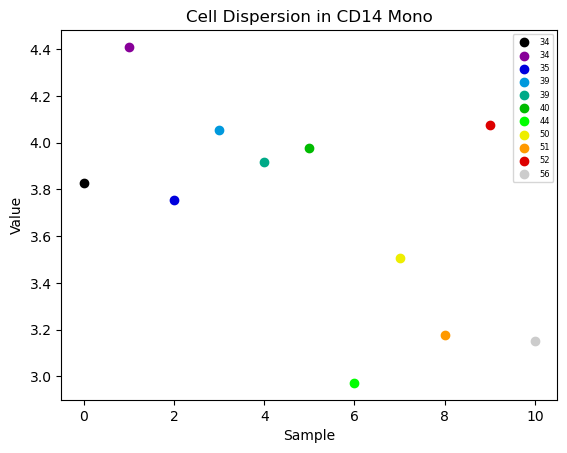

In [125]:
scatter_plot(mean_CD14_Mono, "Cell Dispersion in CD14 Mono", "CD14 Mono")

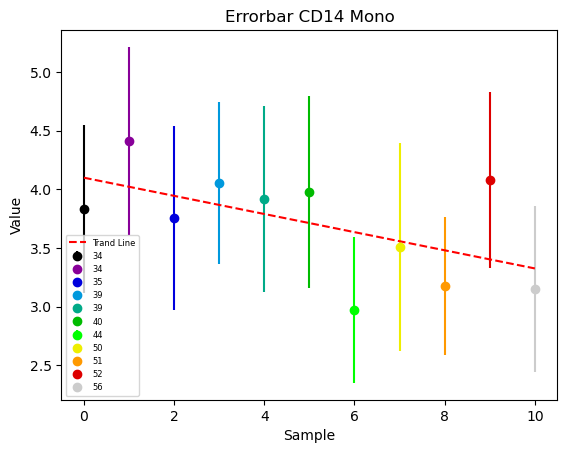

In [137]:
errorbar(mean_CD14_Mono, "Errorbar CD14 Mono", "CD14 Mono")

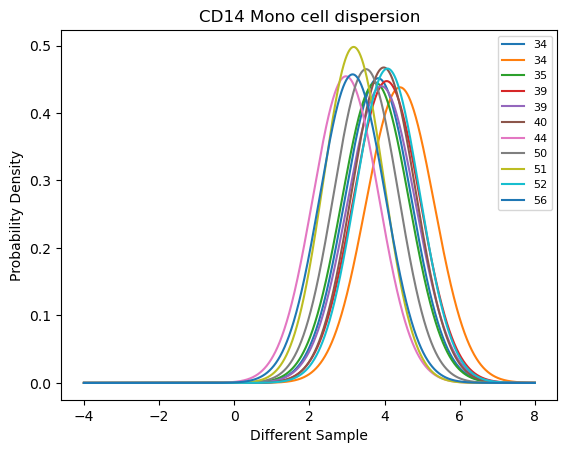

In [127]:
for i in range(0, len(mean_CD14_Mono)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_CD14_Mono[i], std_CD14_Mono[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD14 Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD14 Mono cell dispersion.png', dpi=900)

In [133]:
dispersion_personal_pDC, mean_pDC, std_pDC  = Excute_all(sorted_personal, "pDC")

100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


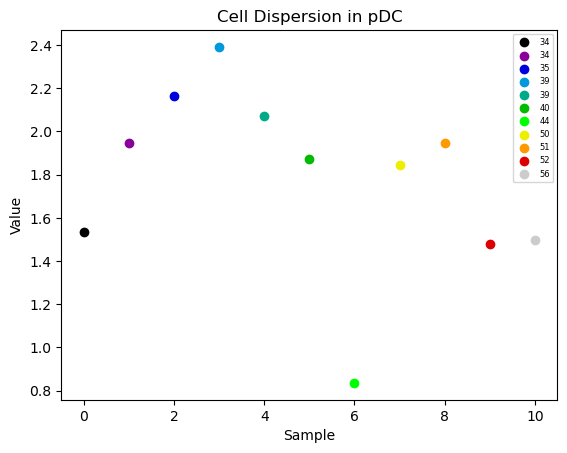

In [134]:
scatter_plot(mean_pDC, "Cell Dispersion in pDC", "pDC")

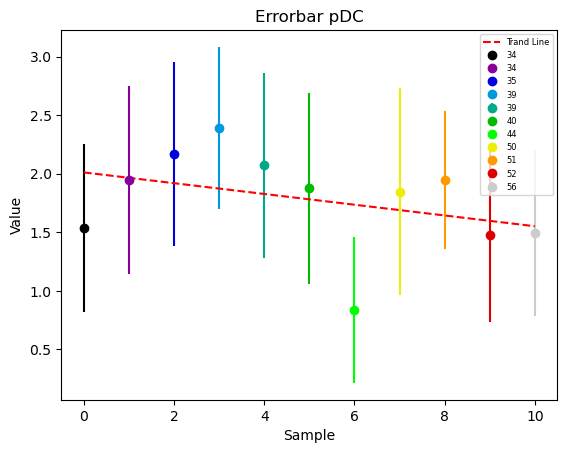

In [135]:
errorbar(mean_pDC, "Errorbar pDC", "pDC")

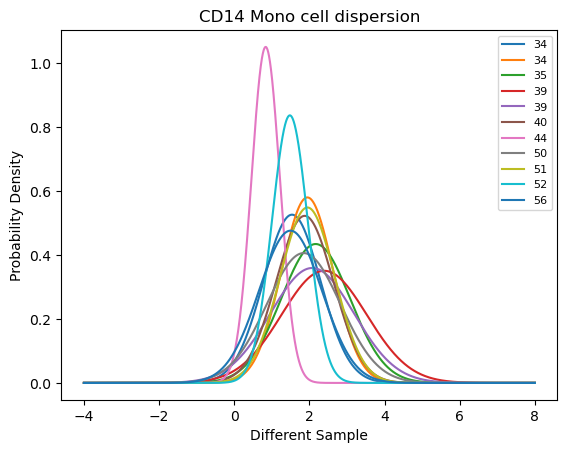

In [136]:
for i in range(0, len(mean_pDC)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_pDC[i], std_pDC[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD14 Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD14 Mono cell dispersion.png', dpi=900)

# Cell type 1

# NK cell dispersion

In [140]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")

100%|██████████| 11/11 [05:36<00:00, 30.59s/it]


In [141]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_NK[count])
    print("Standard Deviation : ", std_NK[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.79295680867513
Standard Deviation :  0.7447826088759842 

SAMN17379698
Age :  34
Mean :  2.92367463663737
Standard Deviation :  0.789057587994144 

SAMN17379697
Age :  35
Mean :  3.161413885904948
Standard Deviation :  0.7909181928813985 

SAMN17379693
Age :  39
Mean :  2.681186393127441
Standard Deviation :  0.7161441167592583 

SAMN17379591
Age :  39
Mean :  2.8208937659708657
Standard Deviation :  0.775570519046309 

SAMN17379696
Age :  40
Mean :  2.8413449677530926
Standard Deviation :  0.8220696950031895 

SAMN17379695
Age :  44
Mean :  2.3736505360921227
Standard Deviation :  0.670108778786479 

SAMN17379671
Age :  50
Mean :  3.206498610534668
Standard Deviation :  0.8380534800080323 

SAMN17379721
Age :  51
Mean :  2.257762483418783
Standard Deviation :  0.5906906798815347 

SAMN17379592
Age :  52
Mean :  2.7588849706014
Standard Deviation :  0.7093576462810934 

SAMN17379590
Age :  56
Mean :  2.424547363535563
Standard Deviation :  0.68270722862

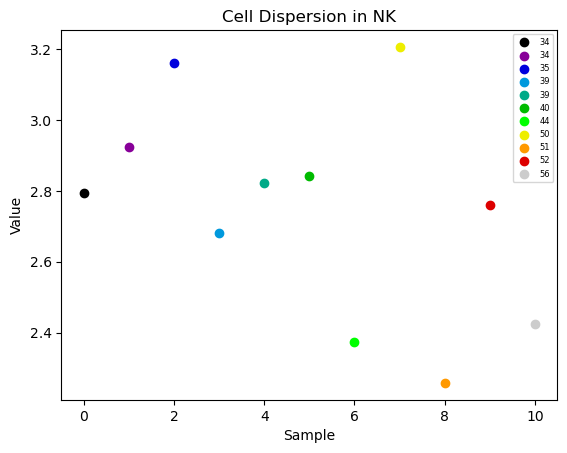

In [142]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK")

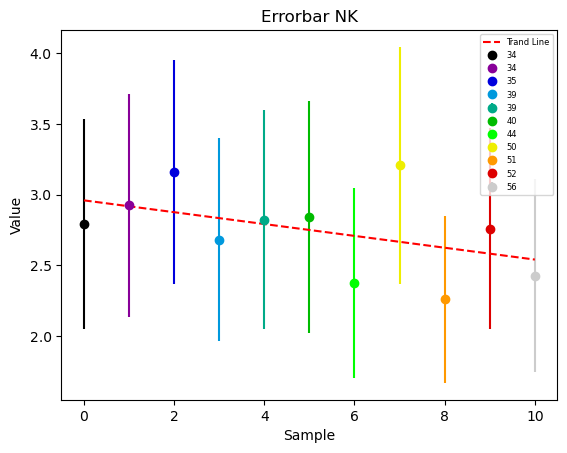

In [143]:
errorbar(mean_NK, "Errorbar NK", "NK")

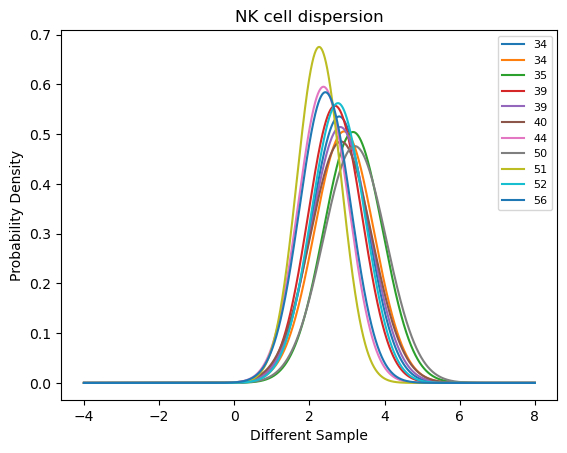

In [144]:
for i in range(0, len(mean_NK)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_NK[i], std_NK[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("NK cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')


# 將圖形保存為PNG文件
plt.savefig('Result_picture/NK cell dispersion.png', dpi=900)

# CD4 T cell dispersion

In [79]:
dispersion_personal_CD4_T, mean_CD4_T, std_CD4_T = Excute_all(sorted_personal, "CD4 T")

100%|██████████| 11/11 [04:10<00:00, 22.73s/it]


In [80]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD4_T[count])
    print("Standard Deviation : ", std_CD4_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.854957990824382
Standard Deviation :  0.7913571302488489 

SAMN17379698
Age :  34
Mean :  2.4195114217122393
Standard Deviation :  0.693877679529804 

SAMN17379697
Age :  35
Mean :  2.9341642020161944
Standard Deviation :  0.8392228162938973 

SAMN17379693
Age :  39
Mean :  2.5031418771362306
Standard Deviation :  0.7310501331844471 

SAMN17379591
Age :  39
Mean :  2.470434684346517
Standard Deviation :  0.798172653530163 

SAMN17379696
Age :  40
Mean :  2.5966612350463865
Standard Deviation :  0.7076898025396495 

SAMN17379695
Age :  44
Mean :  2.1284532385253905
Standard Deviation :  0.6362487510620687 

SAMN17379671
Age :  50
Mean :  2.664006607259114
Standard Deviation :  0.8281639641248348 

SAMN17379721
Age :  51
Mean :  2.1626603685506183
Standard Deviation :  0.6742248197939406 

SAMN17379592
Age :  52
Mean :  2.4705160034179685
Standard Deviation :  0.7577146746619359 

SAMN17379590
Age :  56
Mean :  2.3624089915974937
Standard Deviation :  0.7

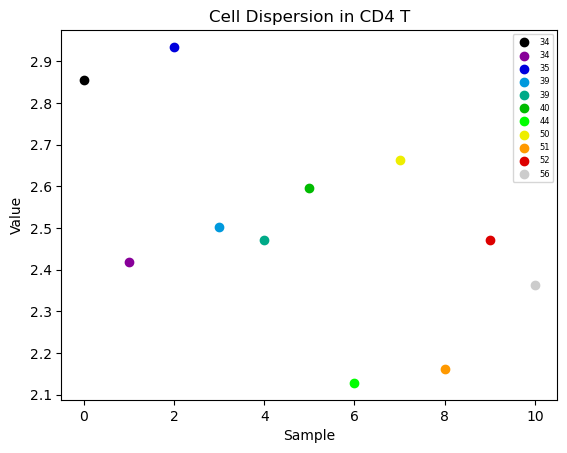

In [81]:
scatter_plot(mean_CD4_T, "Cell Dispersion in CD4 T", "CD4 T")

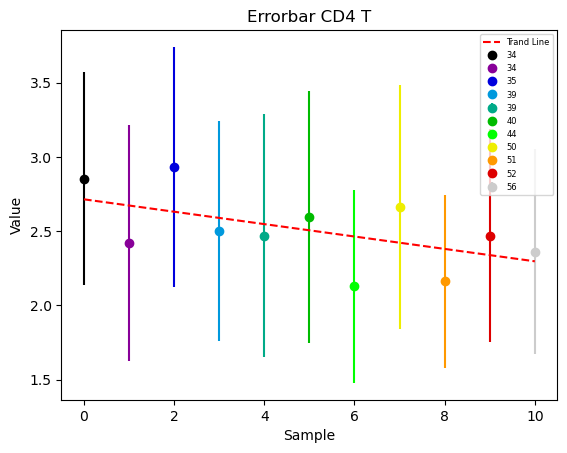

In [82]:
errorbar(mean_CD4_T, "Errorbar CD4 T", "CD4 T")

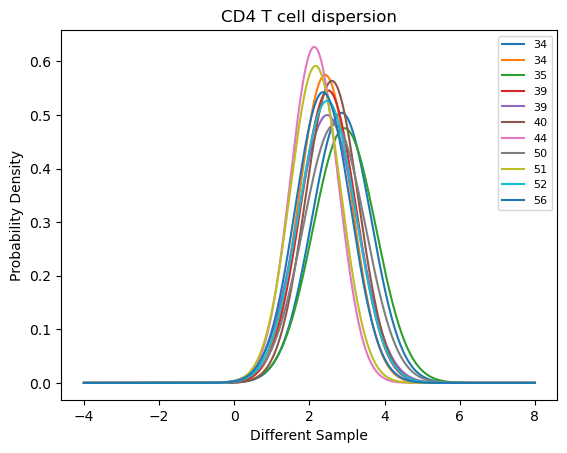

In [83]:
for i in range(0, len(mean_CD4_T)):
    x = np.arange(-4, 8, 0.001)
    y = norm.pdf(x, mean_CD4_T[i], std_CD4_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD4 T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD4T cell dispersion.png', dpi=900)

# CD8 T cell dispersion

In [84]:
dispersion_personal_CD8_T, mean_CD8_T, std_CD8_T = Excute_all(sorted_personal, "CD8 T")

100%|██████████| 11/11 [04:51<00:00, 26.54s/it]


In [85]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_CD8_T[count])
    print("Standard Deviation : ", std_CD8_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.5609699786376954
Standard Deviation :  0.7333958833803266 

SAMN17379698
Age :  34
Mean :  2.921813403828939
Standard Deviation :  0.8197673364285097 

SAMN17379697
Age :  35
Mean :  3.012094138285319
Standard Deviation :  0.7820557730384445 

SAMN17379693
Age :  39
Mean :  2.481531677042643
Standard Deviation :  0.7407628625649999 

SAMN17379591
Age :  39
Mean :  2.747772609303792
Standard Deviation :  0.8428112382090251 

SAMN17379696
Age :  40
Mean :  2.709063547261556
Standard Deviation :  0.7003445082815475 

SAMN17379695
Age :  44
Mean :  2.3146170070393883
Standard Deviation :  0.7079980125780401 

SAMN17379671
Age :  50
Mean :  2.7628907808430987
Standard Deviation :  0.8350480923876498 

SAMN17379721
Age :  51
Mean :  2.343975669809977
Standard Deviation :  0.7482386585156202 

SAMN17379592
Age :  52
Mean :  2.8191419177246098
Standard Deviation :  0.7496436927194746 

SAMN17379590
Age :  56
Mean :  2.5676275536092126
Standard Deviation :  0.77

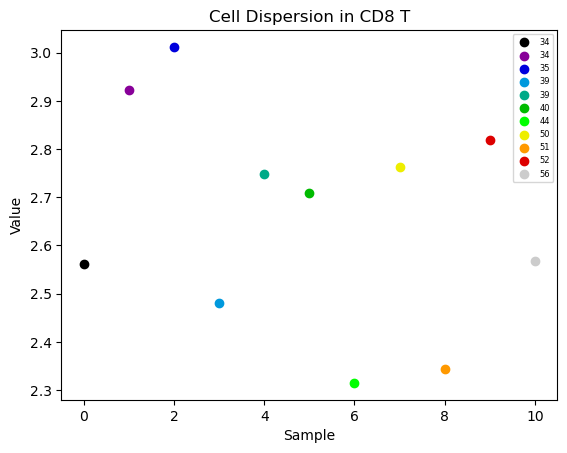

In [86]:
scatter_plot(mean_CD8_T, "Cell Dispersion in CD8 T", "CD8 T")

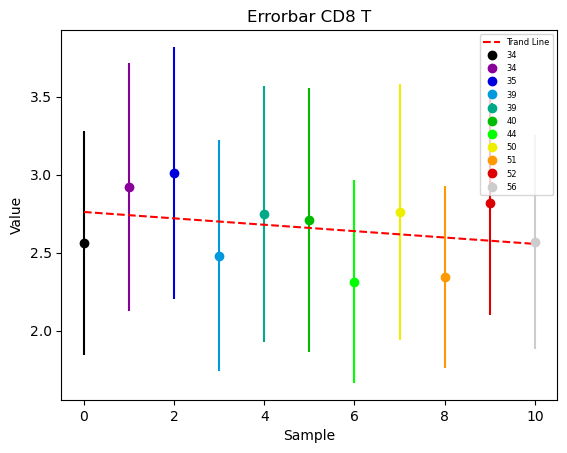

In [87]:
errorbar(mean_CD8_T, "Errorbar CD8 T", "CD8 T")

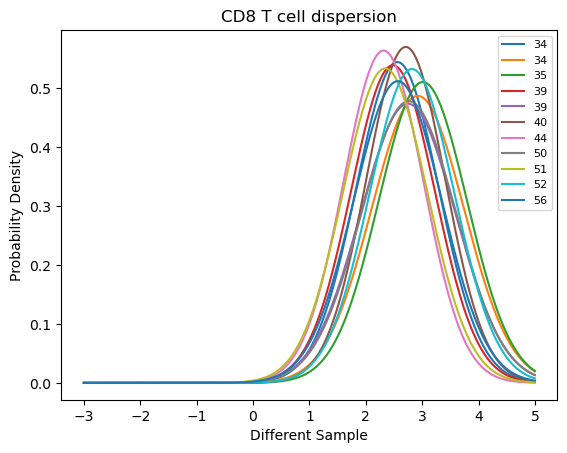

In [88]:
for i in range(0, len(mean_CD8_T)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_CD8_T[i], std_CD8_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("CD8 T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/CD8T cell dispersion.png', dpi=900)

# DC cell dispersion

In [89]:
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")

100%|██████████| 11/11 [00:41<00:00,  3.80s/it]


In [90]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_DC[count])
    print("Standard Deviation : ", std_DC[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.5296580467776977
Standard Deviation :  0.5545603465104679 

SAMN17379698
Age :  34
Mean :  2.9550494135981022
Standard Deviation :  0.45693831600426604 

SAMN17379697
Age :  35
Mean :  3.55099560546875
Standard Deviation :  0.6506298572268185 

SAMN17379693
Age :  39
Mean :  2.428603121329045
Standard Deviation :  0.4341329094453659 

SAMN17379591
Age :  39
Mean :  4.10598424485801
Standard Deviation :  0.7299489180167464 

SAMN17379696
Age :  40
Mean :  3.0699397653773213
Standard Deviation :  0.4477402528613039 

SAMN17379695
Age :  44
Mean :  2.456778171815734
Standard Deviation :  0.47279567257581817 

SAMN17379671
Age :  50
Mean :  3.2829359734576684
Standard Deviation :  0.7472634884979226 

SAMN17379721
Age :  51
Mean :  2.5336528053836544
Standard Deviation :  0.33534998792884363 

SAMN17379592
Age :  52
Mean :  2.8159425054356673
Standard Deviation :  0.4279453588976241 

SAMN17379590
Age :  56
Mean :  3.44604195083397
Standard Deviation :  0.6

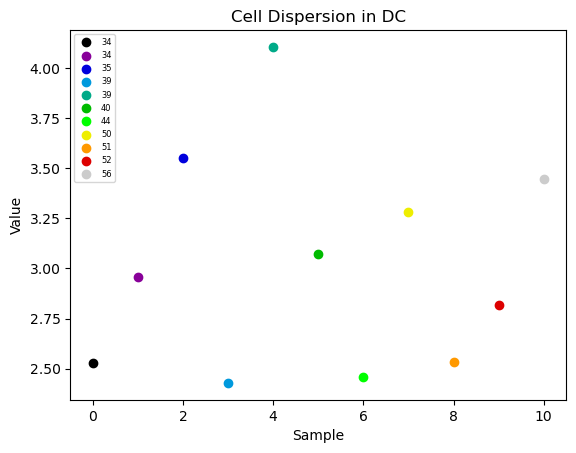

In [91]:
scatter_plot(mean_DC, "Cell Dispersion in DC", "DC")

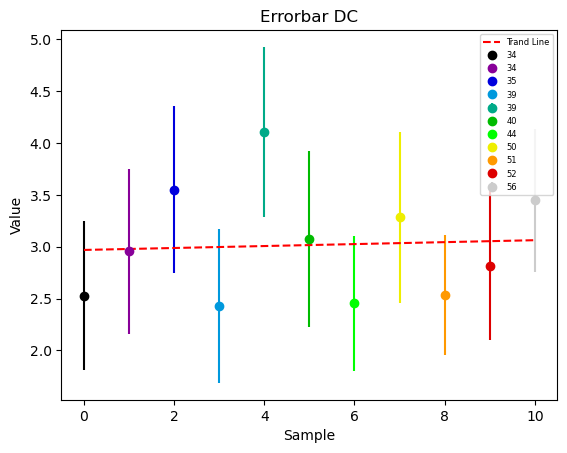

In [92]:
errorbar(mean_DC, "Errorbar DC", "DC")

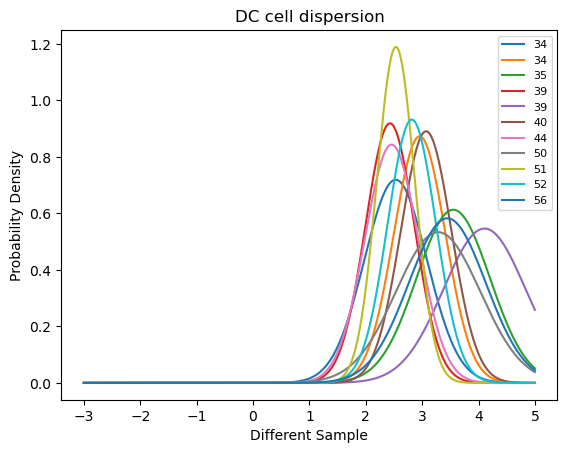

In [93]:
for i in range(0, len(mean_DC)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_DC[i], std_DC[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("DC cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/DC cell dispersion.png', dpi=900)

# Monocyte cell dispersion

In [94]:
dispersion_personal_mono, mean_mono, std_mono = Excute_all(sorted_personal, "Mono")

100%|██████████| 11/11 [05:33<00:00, 30.32s/it]


In [95]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_mono[count])
    print("Standard Deviation : ", std_mono[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  4.043821990661621
Standard Deviation :  0.8658502923222506 

SAMN17379698
Age :  34
Mean :  4.766531312662761
Standard Deviation :  0.9013179199791204 

SAMN17379697
Age :  35
Mean :  3.8263803623453776
Standard Deviation :  0.8698891367967323 

SAMN17379693
Age :  39
Mean :  4.2414290718587235
Standard Deviation :  0.9025430607004814 

SAMN17379591
Age :  39
Mean :  4.364552246907552
Standard Deviation :  0.9456872143901616 

SAMN17379696
Age :  40
Mean :  4.628356584472656
Standard Deviation :  0.8908171664738188 

SAMN17379695
Age :  44
Mean :  3.4995838253784175
Standard Deviation :  0.9432997585164263 

SAMN17379671
Age :  50
Mean :  3.9965367923990884
Standard Deviation :  0.8590884778261054 

SAMN17379721
Age :  51
Mean :  3.5589862897745768
Standard Deviation :  0.8724361251197197 

SAMN17379592
Age :  52
Mean :  4.176788665771484
Standard Deviation :  0.8212618061128845 

SAMN17379590
Age :  56
Mean :  3.4101322933959963
Standard Deviation :  0.8

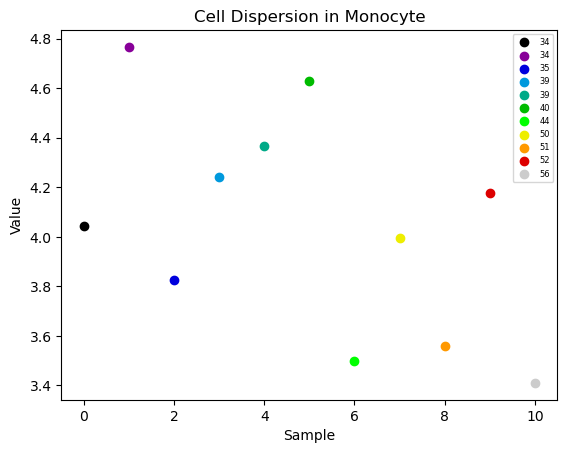

In [96]:
scatter_plot(mean_mono, "Cell Dispersion in Monocyte", "Monocyte")

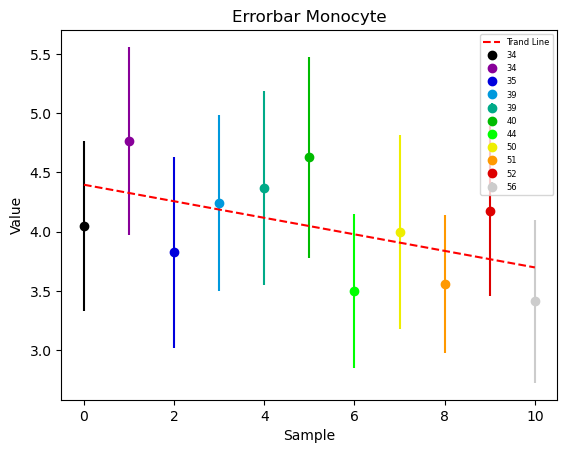

In [97]:
errorbar(mean_mono, "Errorbar Monocyte", "Monocyte")

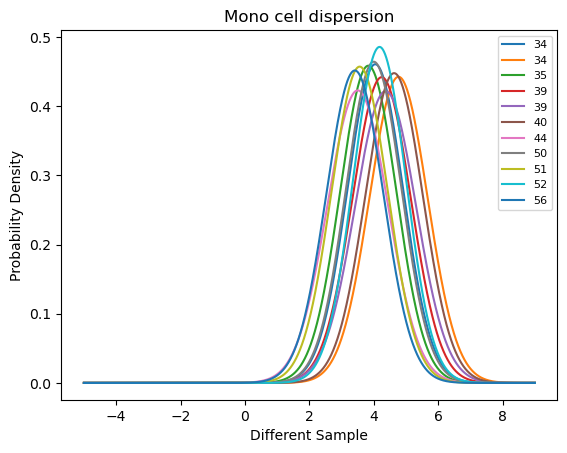

In [98]:
for i in range(0, len(mean_mono)):
    x = np.arange(-5, 9, 0.001)
    y = norm.pdf(x, mean_mono[i], std_mono[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("Mono cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/Mono cell dispersion.png', dpi=900)

# B cell dispersion

In [99]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 11/11 [01:53<00:00, 10.28s/it]


In [100]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_B[count])
    print("Standard Deviation : ", std_B[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.685488749694824
Standard Deviation :  0.6680027529866303 

SAMN17379698
Age :  34
Mean :  2.6316177161661782
Standard Deviation :  0.7223628290009765 

SAMN17379697
Age :  35
Mean :  3.010220239461263
Standard Deviation :  0.6929373560550253 

SAMN17379693
Age :  39
Mean :  2.7473923266601563
Standard Deviation :  0.6893024393677715 

SAMN17379591
Age :  39
Mean :  2.714332990620931
Standard Deviation :  0.5754483609389093 

SAMN17379696
Age :  40
Mean :  2.5529458870442707
Standard Deviation :  0.6309851355459242 

SAMN17379695
Age :  44
Mean :  2.252903009236654
Standard Deviation :  0.5824957070531777 

SAMN17379671
Age :  50
Mean :  2.9855876360066733
Standard Deviation :  0.746869287642482 

SAMN17379721
Age :  51
Mean :  2.4846842431640623
Standard Deviation :  0.6095354947573497 

SAMN17379592
Age :  52
Mean :  2.7400093542480466
Standard Deviation :  0.8112265824797862 

SAMN17379590
Age :  56
Mean :  2.4786723150634766
Standard Deviation :  0.6

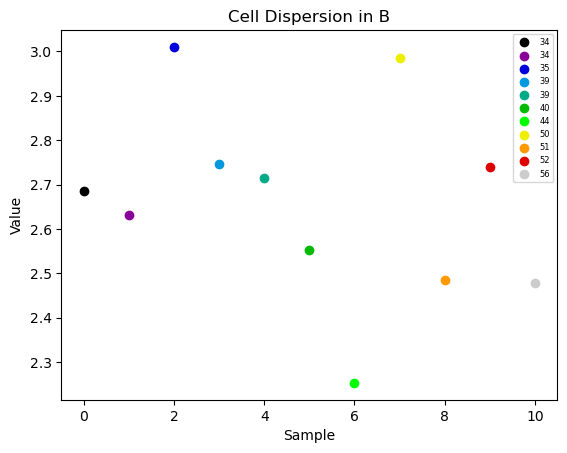

In [101]:
scatter_plot(mean_B, "Cell Dispersion in B", "B")

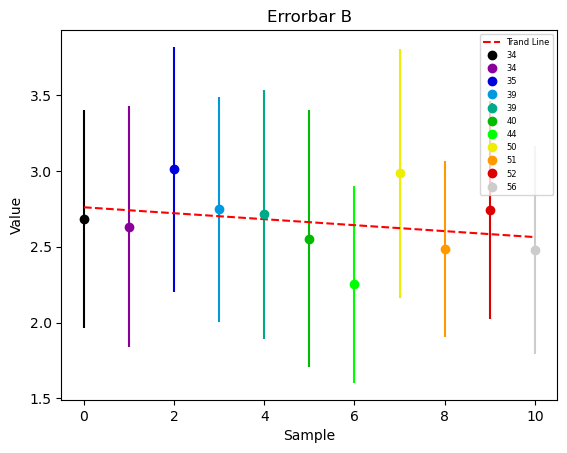

In [102]:
errorbar(mean_B, "Errorbar B", "B")

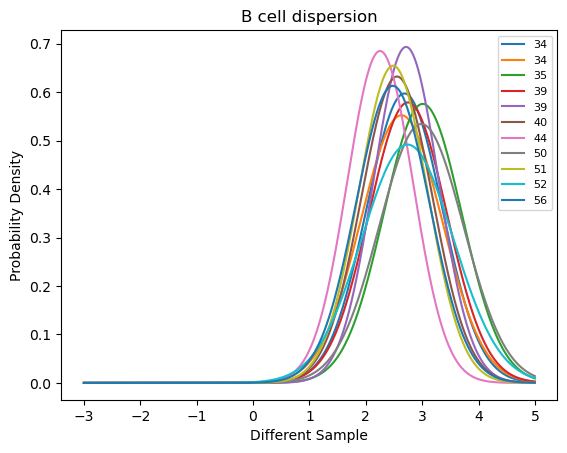

In [103]:
for i in range(0, len(mean_B)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_B[i], std_B[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("B cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/B cell dispersion.png', dpi=900)

# other T cell dispersion

In [148]:
dispersion_personal_other_T, mean_other_T, std_other_T = Excute_all(sorted_personal, "other T")

100%|██████████| 11/11 [01:34<00:00,  8.61s/it]


In [149]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_other_T[count])
    print("Standard Deviation : ", std_other_T[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  2.4537067547607423
Standard Deviation :  0.6408321439515638 

SAMN17379698
Age :  34
Mean :  3.7663499583943687
Standard Deviation :  0.8398544949241945 

SAMN17379697
Age :  35
Mean :  3.195979529113769
Standard Deviation :  0.9435457168486698 

SAMN17379693
Age :  39
Mean :  2.487858219095866
Standard Deviation :  0.6442572183391516 

SAMN17379591
Age :  39
Mean :  1.883367676493327
Standard Deviation :  0.3860918056502437 

SAMN17379696
Age :  40
Mean :  2.8758044847615563
Standard Deviation :  0.7103492632733128 

SAMN17379695
Age :  44
Mean :  2.0408764217122397
Standard Deviation :  0.6056246011680301 

SAMN17379671
Age :  50
Mean :  3.2450389857991535
Standard Deviation :  0.8634190582949127 

SAMN17379721
Age :  51
Mean :  1.9149605137634278
Standard Deviation :  0.4025676957169067 

SAMN17379592
Age :  52
Mean :  3.0775497862752283
Standard Deviation :  0.7434527325807736 

SAMN17379590
Age :  56
Mean :  2.4196176058959957
Standard Deviation :  0

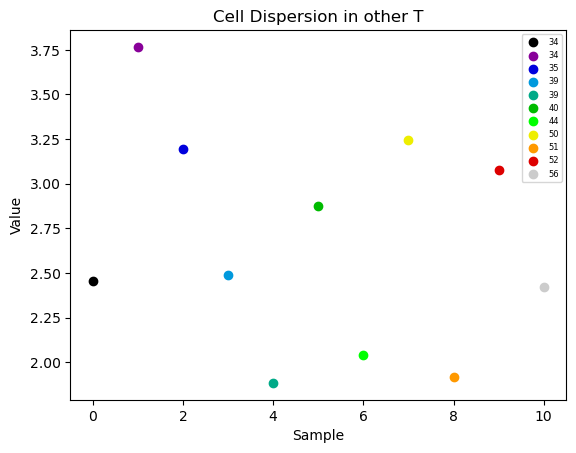

In [150]:
scatter_plot(mean_other_T, "Cell Dispersion in other T", "other T")

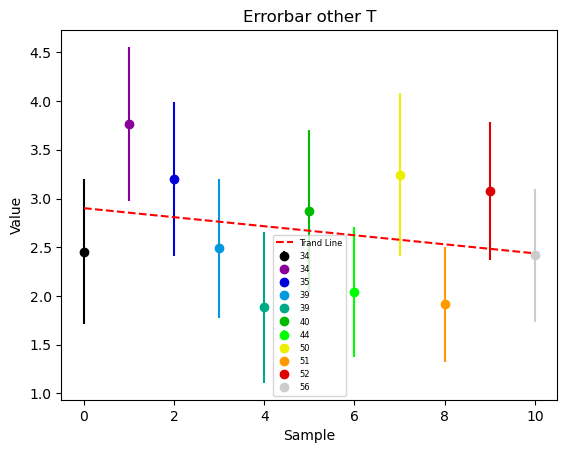

In [151]:
errorbar(mean_other_T, "Errorbar other T", "other T")

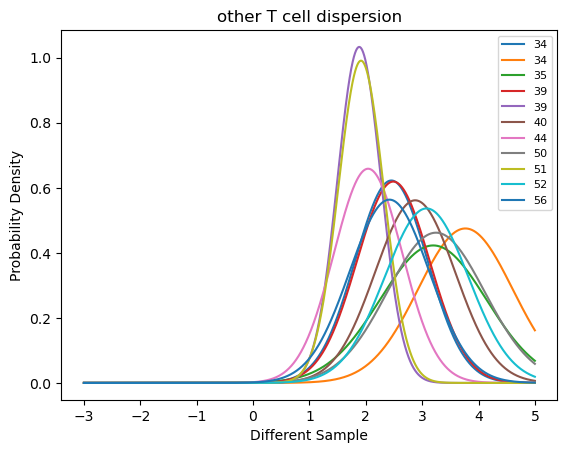

In [152]:
for i in range(0, len(mean_other_T)):
    x = np.arange(-3, 5, 0.001)
    y = norm.pdf(x, mean_other_T[i], std_other_T[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("other T cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/other T cell dispersion.png', dpi=900)

# other cell dispersion

In [109]:
dispersion_personal_other, mean_other, std_other = Excute_all(sorted_personal, "other")

100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


In [110]:
count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_other[count])
    print("Standard Deviation : ", std_other[count], "\n")
    
    count += 1 

SAMN17379694
Age :  34
Mean :  0.41715199184417723
Standard Deviation :  0.11173623547614363 

SAMN17379698
Age :  34
Mean :  1.3289131990273793
Standard Deviation :  0.3790613532969923 

SAMN17379697
Age :  35
Mean :  0.5335973168849946
Standard Deviation :  0.4796080132274118 

SAMN17379693
Age :  39
Mean :  0.7609806562900544
Standard Deviation :  0.35554099278477214 

SAMN17379591
Age :  39
Mean :  0.5871879547595977
Standard Deviation :  0.2349617651690933 

SAMN17379696
Age :  40
Mean :  0.8861872357209524
Standard Deviation :  1.00031167014158 

SAMN17379695
Age :  44
Mean :  0.8834055034001669
Standard Deviation :  0.7321006122744366 

SAMN17379671
Age :  50
Mean :  0.6325370793342591
Standard Deviation :  0.6697866038545345 

SAMN17379721
Age :  51
Mean :  0.9523108776092529
Standard Deviation :  0.4544167886435787 

SAMN17379592
Age :  52
Mean :  0.2740090346654256
Standard Deviation :  0.044270289985794034 

SAMN17379590
Age :  56
Mean :  0.28060728527704876
Standard Deviati

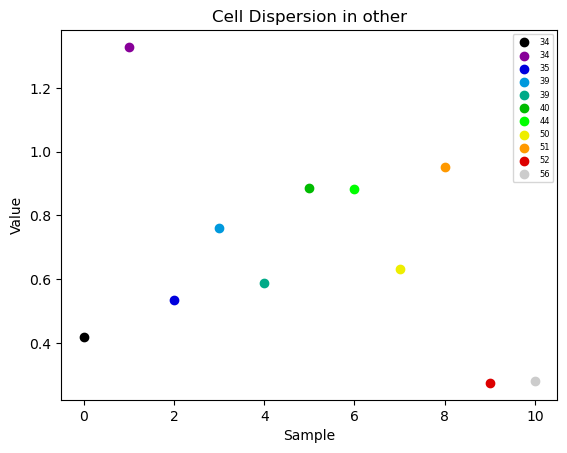

In [111]:
scatter_plot(mean_other, "Cell Dispersion in other", "other")

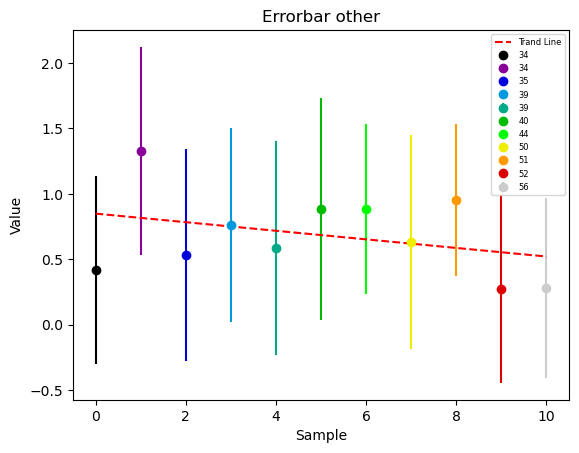

In [112]:
errorbar(mean_other, "Errorbar other", "other")

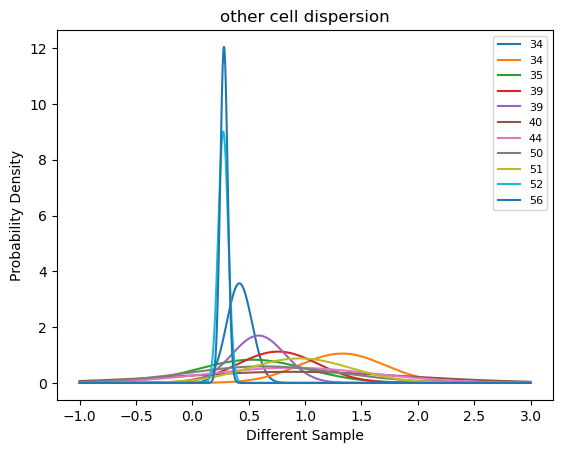

In [113]:
for i in range(0, len(mean_other)):
    x = np.arange(-1, 3, 0.001)
    y = norm.pdf(x, mean_other[i], std_other[i])
    plt.plot(x,y)
    
# 添加圖例
plt.legend(age, fontsize = 8)
# 添加標題和軸標籤
plt.title("other cell dispersion")
plt.xlabel('Different Sample')
plt.ylabel('Probability Density')

# 將圖形保存為PNG文件
plt.savefig('Result_picture/other cell dispersion.png', dpi=900)

In [114]:
import csv
with open('mean_and_stdev.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4_T', 'mean_CD8_T', 'mean_DC', 'mean_mono', 'mean_B', 'mean_other_T', 'mean_other', 'std_NK', 'std_CD4_T', 'std_CD8_T', 'std_DC', 'std_mono', 'std_B', 'std_other_T', 'std_other'])
    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4_T, Mean_CD8_T, Mean_DC, Mean_mono, Mean_B, Mean_other_T, Mean_other, Std_NK, Std_CD4_T, Std_CD8_T, Std_DC, Std_mono, Std_B, Std_other_T, Std_other in zip(sorted_personal, age, mean_NK, mean_CD4_T, mean_CD8_T, mean_DC, mean_mono, mean_B, mean_other_T, mean_other, std_NK, std_CD4_T, std_CD8_T, std_DC, std_mono, std_B, std_other_T, std_other):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4_T, Mean_CD8_T, Mean_DC, Mean_mono, Mean_B, Mean_other_T, Mean_other, Std_NK, Std_CD4_T, Std_CD8_T, Std_DC, Std_mono, Std_B, Std_other_T, Std_other])

In [54]:
"""# 創建一個子圖
fig, ax = plt.subplots()

for i in range(0,len(dispersion_personal)):
    ax.hist(dispersion_personal[i], alpha=0.5,bins = 30, density=True)
    """

'# 創建一個子圖\nfig, ax = plt.subplots()\n\nfor i in range(0,len(dispersion_personal)):\n    ax.hist(dispersion_personal[i], alpha=0.5,bins = 30, density=True)\n    '

In [55]:
# 繪製直方圖
#plt.hist(dispersion_NK, bins=30, density=True)
#plt.xlabel('Dispersion')
#plt.ylabel('Probability Density')

In [56]:
"""# 取得1000次抽樣的離散程度
dispersion_NK_1 = []
for i in range(0,1000):
    # 取得sampling的dataframe
    cell_dispersion_NK_1 = renew_sampling_list(NK_1)
    # 計算 cell * cell distance
    distance_matrix_NK_1 = create_distance_matrix(cell_dispersion_NK_1)
    # 取得此次抽樣的dispersion
    dispersion_NK_1.append(calculate_dispersion(distance_matrix_NK_1))"""

'# 取得1000次抽樣的離散程度\ndispersion_NK_1 = []\nfor i in range(0,1000):\n    # 取得sampling的dataframe\n    cell_dispersion_NK_1 = renew_sampling_list(NK_1)\n    # 計算 cell * cell distance\n    distance_matrix_NK_1 = create_distance_matrix(cell_dispersion_NK_1)\n    # 取得此次抽樣的dispersion\n    dispersion_NK_1.append(calculate_dispersion(distance_matrix_NK_1))'